# Udacity Data Analyst Nanodegree
---
## Project 4: `WeRateDogs` Twitter Analysis - Data Wrangling - Gater, asses, clean and analyse tweets about dog ratings

>**`What its all about`**:  
The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.
WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for you to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. 

(cited from Udacity, on January 24, 2021)

### 1 --- Import libraries

In [1]:
import numpy as np
import json
import pprint
import tqdm
import pandas as pd
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import os
import requests
import tweepy 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# copied from https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### 2 --- Import the `twitter-archive-enhanced-2.csv` file into a pandas dataframe

Using `pandas.read_csv()` function, read in the provided dataframe for further exploration later.

In [4]:
path = os.getcwd()  # for standardising, get the current working directory
data = "twitter-archive-enhanced-2.csv"

tw_archive = pd.read_csv(os.path.join(path, data))
# explore if everything worked smoothly
tw_archive.head(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   

   rating_denominator     name doggo floofer pupper puppo  
0                  10  Phineas  None    None   None  None  
1                  10    Tilly  None    None   None  None  
2                  10   Archie  None    None   None  None

### 3 --- Download the neural network predictions file on dog breeds from the provided URL

In [5]:
def download_url(URL: str, folder_name: str) -> None:
    
    """ Function to download URL data and store it in a specified folder in the
        format, thats predefined in the downloaded file
    """
    
    # if entering an empty function, raise some helpful info
    assert URL is not None, "Pass a URL"
    assert folder_name is not None, "Pass a folder name"
    
    try:
        # create a folder for storing the downloaded data if it does not exist yet
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        response = requests.get(URL)
        # write the file
        with open(os.path.join(folder_name, URL.split("/")[-1]), mode="wb") as f:
            f.write(response.content)
    
    except Exception as e:
        print(e)
        
    finally:
        # show if the file now exists
        print(os.listdir(folder_name))
        print(" Downloading URL data completed ")
        # return the path to the data, so we can easily read it in afterwards
        return os.path.join(folder_name, URL.split("/")[-1])

In [6]:
URL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

In [7]:
URL_file_path = download_url(URL, "network_predictions")

['image-predictions.tsv']


### 4 --- Read the `image-predictions.tsv` file into a pandas dataframe

In [8]:
# the data is a .tsv file, meaning its "tab"-separated
# specify this in the pd.read_csv command accordingly
image_preds = pd.read_csv(os.path.join(os.getcwd(), URL_file_path), sep = "\t")

In [9]:
# check if everything looks fine
image_preds.head(3)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True

### 5 --- Assess further data like retweet and like count from twitter using the `tweepy` API

In [10]:
# we can extract the metadata from tweets using the tweepy library to access hidden information on twitter tweets
# all we need is the unique tweet_id, which is stored in tweet_archive's tweet_id columns
tweet_ids = list(tw_archive["tweet_id"])
tweet_ids[:3]

[892420643555336193, 892177421306343426, 891815181378084864]

In [11]:
# this stores secret keys and token
# replace this with your unique passwords

key = ""
key_secret = ""
access_token = ""
access_secret = ""

auth = tweepy.OAuthHandler(key, key_secret)
auth.set_access_token(access_token, access_secret)

# instantiate the API
api = tweepy.API(auth, wait_on_rate_limit=True,
                wait_on_rate_limit_notify=True)

In [12]:
def download_tweets(tweet_ids: list) -> object:
    
    """ Downloading function to scrape tweet metadata from twitter backend.
        Requires tweet IDs as input (type list).
        Returns a dictionary with failed IDs.
        Writes downloaded tweet data as a "{}.txt" file, formatted in JSON.
    """
    
    # store the information on each tweet in a dictionary: keys are the tweet_id, values = all metadata
    tweet_dict = collections.defaultdict()
    # also save those that fail, in case we want to handle them manually later
    fails = {}
    
    # use a progressbar cause this takes quite long (30 minutes approx.)
    for tweet_id in tqdm.tqdm(tweet_ids):
        
        try:
            tweet_meta = api.get_status(tweet_id, tweet_mode="extended")
            tweet_dict[tweet_id] = tweet_meta._json

        except tweepy.TweepError as e:
            fails[tweet_id] = e
    
    # save JSON data to a .txt file that later can be read in like a dictionary
    with open(os.path.join(os.getcwd(), "tweet_json.txt"), mode="w") as output_file:
        json.dump(tweet_dict, output_file, indent=2)
        
    print(" Downloading Tweet Data succesfully completed ")
    print(" Failed tweets: ")
    pprint.pprint(fails, width = 1)
    
    return fails

######## changed tweet_ids: str to list !!!
### in CASE OF FAIL

In [13]:
fails = download_tweets(tweet_ids)

100%|██████████| 2356/2356 [32:32<00:00,  1.21it/s]    


 Failed tweets: 
{680055455951884288: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 754011816964026368: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 759566828574212096: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 770743923962707968: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 771004394259247104: TweepError([{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]),
 775096608509886464: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 779123168116150273: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 802247111496568832: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 812747805718642688: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 827228250799742977: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 829374341691346946: Tw

In [17]:
def extract_from_tweets(filepath: str):
    
    """ Given a valid filepath including the document name, this function returns
        a dictionary and a pandas dataframe with extracted information on tweets.
        INPUT: filepath
        OUTPUT: tweet_data:
                    keys: tweet_ids
                    values: all json metadata from a given tweet
                tweet_df:
                    Pandas DataFrame object containg columns for tweet_id,
                    retweet_count and favorite_count
    """
    
    filepath = os.path.join(os.getcwd(), filepath)
    
    # store data as a dictionary first
    tweet_data = {}
    # then, from this dictionary extract items of interest, append them to the list,
    # and later convert them into a pandas df
    df_list = []
            
    try: 
        # load all JSON data into a dict (key=tweet_id, value=metadata from tweet)
        with open(filepath) as file:
            tweet_data = json.load(file)            
        
        # iterate through the dictionary
        for tweet_id, tweet_meta in tweet_data.items():
            
            # tweet_data[tweet_id] = tweet_meta ????????????
            # append a list of dictionarys to the df_list
            # the keys will later be converted to the column names, the values are the df values
            df_list.append( {"tweet_id": tweet_id,
                             "retweet_count": tweet_meta["retweet_count"],
                             "favorite_count": tweet_meta["favorite_count"]} 
                          )
    # if there are some issues, just ignore them        
    except:
        pass
    
    # convert the df_list into a pandas dataframe
    tweet_df = pd.DataFrame(df_list, columns = ["tweet_id", "retweet_count", "favorite_count"])
        
    return tweet_data, tweet_df


In [18]:
tweet_data, tweet_df = extract_from_tweets("tweet_json.txt")

### 6 --- Assessing, cleaning, analysing
___
Currently the workspace contains three dataframes:  
1. `tw_archive` - containing tweet text, rating and dog category.
2. `image_pred` - containing a neural network's prediction on the dog breed.
3. `tweet_df` - containing additional information retweet counts and likes.


In this notebook I will follow the "identify-code-test" procedure, meaning after I identified an issue, I will directly choose an appropriate method to solve it, write it out in code and then test wheter the cleaning has worked. This way I can be sure not to miss anything later.
We will start by creating copies of the datasets, in case we mess something up, we can directly refer to the originals instead of having to recreate them from source.

Then we will explore the datasets randomly using standard python functions like .head( ), .describe( ), .info( ) and see if we can identify any data quality or tidiness issues.

In [19]:
# create copies first
tweets = tw_archive.copy()
preds = image_preds.copy()
add_info = tweet_df.copy()

#### tweets

In [20]:
tweets.head(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   

   rating_denominator     name doggo floofer pupper puppo  
0                  10  Phineas  None    None   None  None  
1                  10    Tilly  None    None   None  None  
2                  10   Archie  None    None   None  None

In [21]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
tweets.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

#### predictions

In [23]:
preds.head(3)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True

In [24]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
preds.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

#### additional info -> retweet_count and favorite_count

In [26]:
add_info.head(3)

tweet_id  retweet_count  favorite_count
0  892420643555336193           7415           35150
1  892177421306343426           5517           30419
2  891815181378084864           3639           22870

In [27]:
add_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [28]:
add_info.describe()

retweet_count  favorite_count
count    2331.000000     2331.000000
mean     2606.021879     7341.151437
std      4408.911552    11400.942486
min         1.000000        0.000000
25%       529.000000     1275.000000
50%      1216.000000     3186.000000
75%      3023.500000     8981.500000
max     74831.000000   151222.000000

### 7 --- Cleaning plan
> The WeRateDogs dataset is a really open-ended collection of tweets and not something to be compared to the statistical test results of a medical trial. Therefore many values/descriptions are having weird values just for fun, that does not necessarily mean to be wrong. For instance the dogs Ratings (13/10) is something very interesting, that in other situations might be considered as totally wrong. Herein however is a kind of running gag to give these funny dogs more points than possible and this even made the WeRateDogs account famous for. So this is something we will definetly not change.
---

#### `tweets` issues
>**completeness**  
* I did not find any issues of completeness that we could solve. Most of this datset contains text or image data, and in case of missing / NaN values, theres noting we could use like imputing them with a statistical calculation, like the mean.

>**data types**   
* tweet_id is int64
* timestamp is type object, convert it to pandas datetime
* retweeted_status_timestamp is type object, convert it to pandas datetime
* in_reply_to_status_id is int64
* in_reply_to_user_id is int64

>**validity / accuracy**  
* valid, but maybe wrong dog names


#### `preds` issues
>**completeness**  
 * missing data, not restorable as neural net is not provided

>**tidiness**  
* dog (1-3) and conf (1-3) are individual columns, melt down
* tweet_id is int64

#### `add_info` issues
>**completeness**    
* missing data for 25 tweets

>**data types**   
* tweet_id is int64

#### `global tidiness `
* currently we are having three tables. These can be converted into one master df. As some issues that would need to be cleaned are similar / same accross these three datasets, it makes sense to first merge them and then address all issues on one single dataframe instead of repeting it thrice.

## 8 --- Data cleaning: Define, code, test
___


`tweets`
>**data types**   
> It is helpful to first convert the datatype of the `tweet_id` column from numeric (int64) to string. This will make joining the dataframes using .merge( ) easier afterawrds.

**Define**: `tweet_id` is type int64 in all three dataframes and in the master_df. This is not too useful as to my knowledge there is no meaningful computation that we could perform on it (like addition, mean or anything else).  
**Code**: convert it to type str in master_df only, as this is the only one we're going to use later  
**Test**: control `tweet_id` column type using pd.Series.astype()  

In [30]:
# Code
df_list = [tweets, preds, add_info]
df_names = list(str(df_list))
for df in df_list:
    df["tweet_id"] = df.tweet_id.astype(str)
    assert df["tweet_id"].dtype == "O"

In [31]:
# Test
for df in df_list:
    print(df.tweet_id.dtype)

object
object
object


#### `global tidiness `
* currently we are having three tables. These can be converted into one master df. As some issues that would need to be cleaned are similar / same accross these three datasets, it makes sense to first merge them and then address all issues on one single dataframe instead of repeting it thrice.

After converting the tweet_id column to string, merge the dataframes. This makes handling overlapping issues with datatypes for instance easier and less repetetive.

**Define**: Currently, all three dataframes are seperated   
**Code**: combine the three dataframes into one `master_df` using pandas.merge( ) with an outer join on tweet_id, meaning all available keys will be used. Therefore some columns might not contain information.  
**Test**: Assert the length of the master_df == the length of the longest dataframe before

In [32]:
master_df = pd.merge(tweets, preds, how="outer", on="tweet_id")
master_df = pd.merge(master_df, add_info, how="outer", on="tweet_id")

assert master_df.shape[0] == tweets.shape[0] 

In [33]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       2

In [34]:
# control that there is no duplicate unique tweet_id that violates validity issues
assert not master_df["tweet_id"].duplicated().sum()

---

#### `add_info` issues
>**completeness**    
* missing data for 25 tweets

**Define**: `retweet_count` and `favorite_count` have missing values, impute with a valid count  
**Code**: use the median to fill in missing values  
**Test**: assert by .info( )  

In [35]:
# count the number of missing values in the respective columns
print(master_df.retweet_count.isna().sum())
print(master_df.favorite_count.isna().sum())

25
25


In [39]:
# get the row indices where the respective column contains a NaN-cell
retweet_idxs = master_df[master_df.retweet_count.isna()].index
favorite_idxs = master_df[master_df.favorite_count.isna()].index

# get the median of the respective column, ignoring NaN
retweet_count_median = master_df.retweet_count.median()
favorite_count_median = master_df.favorite_count.median()

In [40]:
# fill the missing values using a key=column : value=column_median dict
master_df.fillna( {"retweet_count": retweet_count_median, 
                   "favorite_count": favorite_count_median},
                  axis = 0, inplace = True 
                )

In [42]:
# make sure all NaN have been replaced correctly
print((master_df.loc[retweet_idxs, "retweet_count"] == retweet_count_median).all())
print((master_df.loc[favorite_idxs, "favorite_count"] == favorite_count_median).all())

True
True


In [43]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       2

### 8: Coersion: Converting data types
>**data types**   
* timestamp is type object, convert it to pandas datetime
* retweeted_status_timestamp is type object, convert it to pandas datetime
* in_reply_to_status_id is int64
* in_reply_to_user_id is int64

**Define**: `tweets["timestamp"]` is of type object (string)    
**Code**: convert it to type datetime using `pd.to_datetime(df.Series)`  
**Test**: check using pd.Series.astype()

In [44]:
# convert respective columns to pandas Time Series and check if worked properly
master_df["timestamp"] = pd.to_datetime(master_df.timestamp)
master_df["retweeted_status_timestamp"] = pd.to_datetime(master_df["retweeted_status_timestamp"])
print(master_df.timestamp.dtype)
print(master_df.retweeted_status_timestamp.dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]


**Define**: `retweet_count` and `favorite_count` are decimals  
**Code**: convert it to type int using `.astype(int)`    
**Test**: check using pd.Series.astype()

In [45]:
master_df["retweet_count"] = master_df.retweet_count.astype(int)
master_df["favorite_count"] = master_df.favorite_count.astype(int)
print(master_df.retweet_count.dtype)
print(master_df.favorite_count.dtype)

int64
int64


**Define**: `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_status_id`  and `in_reply_to_user_id` are float64 but should be str  
**Code**: convert it to type int using `.astype(str)`    
**Test**: check using pd.Series.astype()

In [46]:
# we cannot perform any useful computations on these columns, so convert them to string
cols = ["retweeted_status_id", "retweeted_status_user_id", "in_reply_to_status_id", "in_reply_to_user_id"]
for col in cols:
    master_df[col] = master_df[col].astype(str)
    assert master_df[col].dtype == "O"

In [48]:
# check types
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg

---

>**validity / accuracy**  
* valid, but maybe wrong dog names

**Define**: the `master_df.name` column contains some names like "a", "the", "an". This is an accuracy issue, as these are valid dog names if the owner likes them, but most likely to be incorrect. Most of th tweets start with `"This is .."` and in order to crop the dog name probably a regex extracting the first word after `this is` was used. The way to solve this is: Names start with a Capital letter, while words like "a", "the" don't.  
**Code**: Replace wrong names with names that are found in the text of the matching tweet, given that the name exists already in the .name column.  
**Test**: Use .info()

In [40]:
master_df.name.nunique()

957

In [50]:
# check the top 20 names
master_df.name.value_counts()[:20]

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
Lola        10
Penny       10
Tucker      10
Winston      9
Bo           9
the          8
Sadie        8
Toby         7
an           7
Daisy        7
Bailey       7
Buddy        7
Leo          6
Rusty        6
Name: name, dtype: int64

In [51]:
# check if we can manually see the (most likely correct) name in the text
master_df.loc[master_df.name=="a", "text"]
master_df.loc[master_df.name=="an", "text"]
master_df.loc[master_df.name=="the", "text"]

1527    Stop sending in lobsters. This is the final wa...
1603    This is the newly formed pupper a capella grou...
1797    This is the happiest pupper I've ever seen. 10...
1815    This is the saddest/sweetest/best picture I've...
2037    This is the best thing I've ever seen so sprea...
2212    Never forget this vine. You will not stop watc...
2345    This is the happiest dog you will ever see. Ve...
2346    Here is the Rand Paul of retrievers folks! He'...
Name: text, dtype: object

In [52]:
# it appears that the algorithm to find the names, extracted them as the 3 word in the sentence, ...
# as most posts start with "This is (dog_name)", but sometimes catches it wrong. Most likely true dog names are capital letters,
# while those that are possibly wrong are lowercase

# create a dataframe with rows containing lowercase dog namess
wrong_names_df = master_df.loc[master_df.name.str.islower(),:]

In [54]:
possib_wrong = wrong_names_df.name.unique()
possib_wrong

# as we can see, most likely all these are not true dog names (though they might be valid dog names)

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [71]:
# create a function to replace those possibly wrong dog names
# for all that are possibly wrong, check the tweet text, see if we find a word that is in the possible true name list (names), then replace it

def replace_names():
    
    """ This function is to clean names as follows:
        It first computes unique names in the master_df, then removes possible wrong names 
        like 'a', 'the', 'an' to create a unique set of "names". Then we iterate through 
        the wrong_names_df, crop tweet_id and the text column and check wheter any word in 
        the text is in our names arry. If yes, we store tweet_id and name in replacements.
    """

    replacements = {}
    # all existing names
    names = master_df.name.unique()
    # all names without possible wrong names
    names = np.setdiff1d(names, possib_wrong)   # remove all names from the "wrong" array from the "names" array
    
    # iterate through rows
    for sub in wrong_names_df.iterrows():

        tweet_id = sub[1]["tweet_id"]
        txt = sub[1]["text"]
        txt = txt.replace(".", "")
        txt = txt.replace(",", "")

        for word in txt.split(" "):
            if word in names:
                # if the one of the pre-existing names occurs in the text, save it in the replacements dict
                replacements[tweet_id] = word

    return replacements

In [72]:
# iterate through the dictionary
for tweet_id, name in replacements.items():
    # check that names are not possibly wrong
    if not name.islower():
        # replace the existing wrong names with the true names
        master_df.loc[master_df.tweet_id==tweet_id, "name"] = name

In [73]:
# of curese we didnt clean all issues here
# if the wrong name is stil in the dataframe, replace it with None
master_df.loc[master_df.name.isin(possib_wrong), "name"] = "None"    

In [74]:
master_df.name.value_counts()

None       845
Charlie     12
Cooper      11
Lucy        11
Oliver      11
          ... 
Augie        1
Emanuel      1
Butters      1
Darrel       1
Herb         1
Name: name, Length: 932, dtype: int64

In [75]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg

---

>**tidiness**  
* dog (1-3) and conf (1-3) are individual columns, melt down

**Define**: Dog categories are in own columns: `doggo`, `floofer`, `pupper`, `puppo`        
**Code**: Melt the dataframe and coerce to `category`   
**Test**: Use .info()   

In [77]:
# define columns we melt and those we keep as index cols
melt_cols = ["doggo", "floofer", "pupper", "puppo"]
id_cols = master_df.columns.difference(melt_cols)
id_cols

Index(['expanded_urls', 'favorite_count', 'img_num', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'jpg_url', 'name', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'rating_denominator', 'rating_numerator', 'retweet_count',
       'retweeted_status_id', 'retweeted_status_timestamp',
       'retweeted_status_user_id', 'source', 'text', 'timestamp', 'tweet_id'],
      dtype='object')

In [81]:
# melt the dog categories columns into an value and variable column
# store the dataframe as a new one, in case we break something

master_df_m = master_df.melt(id_vars = id_cols,
                            value_vars = melt_cols,
                            var_name = "titles",
                            value_name = "dog_cat")

# drop non usable column
master_df_m.drop("titles", axis=1, inplace=True)

In [82]:
master_df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 27 columns):
expanded_urls                 9188 non-null object
favorite_count                9424 non-null int64
img_num                       8300 non-null float64
in_reply_to_status_id         9424 non-null object
in_reply_to_user_id           9424 non-null object
jpg_url                       8300 non-null object
name                          9424 non-null object
p1                            8300 non-null object
p1_conf                       8300 non-null float64
p1_dog                        8300 non-null object
p2                            8300 non-null object
p2_conf                       8300 non-null float64
p2_dog                        8300 non-null object
p3                            8300 non-null object
p3_conf                       8300 non-null float64
p3_dog                        8300 non-null object
rating_denominator            9424 non-null int64
rating_numerator        

In [83]:
master_df_m.dog_cat.value_counts()

None       9030
pupper      257
doggo        97
puppo        30
floofer      10
Name: dog_cat, dtype: int64

---

We now run into the issue, that each tweet_id should be represented 4 times in the dataset (for each dog category).
Lets quickly verify this by sorting based on the tweet_id (quickly convert it to numeric to improve sorting on numbers instead of string), sort, then convert it back to string.

In [84]:
master_df_m.tweet_id = master_df_m.tweet_id.astype(int)
master_df_m.sort_values("tweet_id", ascending=False, inplace=True)
master_df_m.tweet_id = master_df_m.tweet_id.astype(str)

In [85]:
master_df_m[["tweet_id","dog_cat"]].head(20)

tweet_id dog_cat
0     892420643555336193    None
2356  892420643555336193    None
7068  892420643555336193    None
4712  892420643555336193    None
7069  892177421306343426    None
4713  892177421306343426    None
1     892177421306343426    None
2357  892177421306343426    None
4714  891815181378084864    None
7070  891815181378084864    None
2     891815181378084864    None
2358  891815181378084864    None
3     891689557279858688    None
7071  891689557279858688    None
4715  891689557279858688    None
2359  891689557279858688    None
7072  891327558926688256    None
4716  891327558926688256    None
2360  891327558926688256    None
4     891327558926688256    None

**Define**: Every sample exists 4 times now. Some are naturally None, some have a `dog_cat` value and 3 remaining None    
**Code**: From those containing a `dog_cat` value keep this explicitly, from those with None keep any of the 4 duplicates.   
**Test**: Use .info()   

In [88]:
# create a df that holds unique tweet_ids only, use keep="last" to store the last row of a duplicated one only
no_duplicates = master_df_m.drop_duplicates(["tweet_id", "dog_cat"], keep="last")

In [89]:
# this dataframe contains all rows, where the dog category was known (and not None)
contains_dog_cat = master_df_m[master_df_m.dog_cat != "None"]

In [90]:
no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2750 entries, 4712 to 9423
Data columns (total 27 columns):
expanded_urls                 2685 non-null object
favorite_count                2750 non-null int64
img_num                       2409 non-null float64
in_reply_to_status_id         2750 non-null object
in_reply_to_user_id           2750 non-null object
jpg_url                       2409 non-null object
name                          2750 non-null object
p1                            2409 non-null object
p1_conf                       2409 non-null float64
p1_dog                        2409 non-null object
p2                            2409 non-null object
p2_conf                       2409 non-null float64
p2_dog                        2409 non-null object
p3                            2409 non-null object
p3_conf                       2409 non-null float64
p3_dog                        2409 non-null object
rating_denominator            2750 non-null int64
rating_numerator     

In [91]:
contains_dog_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 9 to 6729
Data columns (total 27 columns):
expanded_urls                 388 non-null object
favorite_count                394 non-null int64
img_num                       334 non-null float64
in_reply_to_status_id         394 non-null object
in_reply_to_user_id           394 non-null object
jpg_url                       334 non-null object
name                          394 non-null object
p1                            334 non-null object
p1_conf                       334 non-null float64
p1_dog                        334 non-null object
p2                            334 non-null object
p2_conf                       334 non-null float64
p2_dog                        334 non-null object
p3                            334 non-null object
p3_conf                       334 non-null float64
p3_dog                        334 non-null object
rating_denominator            394 non-null int64
rating_numerator              394 non-null

In [92]:
# now drop the rows from no_duplicates dataframe that are contained in the contains_dog_cat df,
# then append both dataframes

contains_ids = list(contains_dog_cat.tweet_id)
print(len(contains_ids))
print(no_duplicates.tweet_id.nunique())

394
2356


In [94]:
# now remove all those that are in the "contains_dog_cat" dataframe from the no_duplicates df, (~ is the not operator)
# like this later when appending both dataframes we will not have duplicates

no_duplicates = no_duplicates.loc[~no_duplicates.tweet_id.isin(contains_ids),:]

In [95]:
no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 4712 to 9423
Data columns (total 27 columns):
expanded_urls                 1923 non-null object
favorite_count                1976 non-null int64
img_num                       1754 non-null float64
in_reply_to_status_id         1976 non-null object
in_reply_to_user_id           1976 non-null object
jpg_url                       1754 non-null object
name                          1976 non-null object
p1                            1754 non-null object
p1_conf                       1754 non-null float64
p1_dog                        1754 non-null object
p2                            1754 non-null object
p2_conf                       1754 non-null float64
p2_dog                        1754 non-null object
p3                            1754 non-null object
p3_conf                       1754 non-null float64
p3_dog                        1754 non-null object
rating_denominator            1976 non-null int64
rating_numerator     

In [105]:
complete_df = no_duplicates.append(contains_dog_cat)

In [106]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 4712 to 6729
Data columns (total 27 columns):
expanded_urls                 2311 non-null object
favorite_count                2370 non-null int64
img_num                       2088 non-null float64
in_reply_to_status_id         2370 non-null object
in_reply_to_user_id           2370 non-null object
jpg_url                       2088 non-null object
name                          2370 non-null object
p1                            2088 non-null object
p1_conf                       2088 non-null float64
p1_dog                        2088 non-null object
p2                            2088 non-null object
p2_conf                       2088 non-null float64
p2_dog                        2088 non-null object
p3                            2088 non-null object
p3_conf                       2088 non-null float64
p3_dog                        2088 non-null object
rating_denominator            2370 non-null int64
rating_numerator     

---

Check out some individual columns from the melted and rejoined dataframe (`complete_df`). As we can see, some dogs have multiple categories ...

In [116]:
# create an array of duplicate values
duplicates = complete_df.loc[complete_df.tweet_id.duplicated(),"tweet_id"]
# use this array to slice the complete_df for duplicates and print them to see whats going on here 
complete_df.loc[complete_df.tweet_id.isin(duplicates.values), :]

expanded_urls  favorite_count  \
7259  https://twitter.com/dog_rates/status/855851453...           43387   
191   https://twitter.com/dog_rates/status/855851453...           43387   
200   https://twitter.com/dog_rates/status/854010172...           15435   
2556  https://twitter.com/dog_rates/status/854010172...           15435   
5172  https://twitter.com/dog_rates/status/817777686...           10600   
460   https://twitter.com/dog_rates/status/817777686...           10600   
5243  https://twitter.com/dog_rates/status/808106460...            8722   
531   https://twitter.com/dog_rates/status/808106460...            8722   
565   https://twitter.com/dog_rates/status/802265048...            6872   
5277  https://twitter.com/dog_rates/status/802265048...            6872   
575   https://twitter.com/dog_rates/status/801115127...            7998   
5287  https://twitter.com/dog_rates/status/801115127...            7998   
705   https://twitter.com/dog_rates/status/785639753...            7771   
5417  https://twitter.com/dog_rates/status/785639753...            7771   
5445                      https://vine.co/v/5rgu2Law2ut            7044   
733                       https://vine.co/v/5rgu2Law2ut            7044   
778   https://twitter.com/dog_rates/status/733109485...               0   
5490  https://twitter.com/dog_rates/status/733109485...               0   
822   https://twitter.com/dog_rates/status/741067306...               0   
5534  https://twitter.com/dog_rates/status/741067306...               0   
5601  https://twitter.com/dog_rates/status/759793422...            5814   
889   https://twitter.com/dog_rates/status/759793422...            5814   
956   https://twitter.com/dog_rates/status/751583847...            4279   
5668  https://twitter.com/dog_rates/status/751583847...            4279   
5775  https://twitter.com/dog_rates/status/741067306...            9228   
1063  https://twitter.com/dog_rates/status/741067306...            9228   
1113  https://twitter.com/dog_rates/status/733109485...           51494   
5825  https://twitter.com/dog_rates/status/733109485...           51494   

      img_num in_reply_to_status_id in_reply_to_user_id  \
7259      1.0                   nan                 nan   
191       1.0                   nan                 nan   
200       1.0                   nan                 nan   
2556      1.0                   nan                 nan   
5172      1.0                   nan                 nan   
460       1.0                   nan                 nan   
5243      1.0                   nan                 nan   
531       1.0                   nan                 nan   
565       1.0  7.33109485275861e+17        4196983835.0   
5277      1.0  7.33109485275861e+17        4196983835.0   
575       1.0                   nan                 nan   
5287      1.0                   nan                 nan   
705       1.0                   nan                 nan   
5417      1.0                   nan                 nan   
5445      NaN                   nan                 nan   
733       NaN                   nan                 nan   
778       1.0                   nan                 nan   
5490      1.0                   nan                 nan   
822       1.0                   nan                 nan   
5534      1.0                   nan                 nan   
5601      2.0                   nan                 nan   
889       2.0                   nan                 nan   
956       1.0                   nan                 nan   
5668      1.0                   nan                 nan   
5775      1.0                   nan                 nan   
1063      1.0                   nan                 nan   
1113      1.0                   nan                 nan   
5825      1.0                   nan                 nan   

                                                jpg_url    name  \
7259    https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg    None   
191     https://pbs.

In [117]:
complete_df[complete_df.tweet_id=="855851453814013952"]

expanded_urls  favorite_count  \
7259  https://twitter.com/dog_rates/status/855851453...           43387   
191   https://twitter.com/dog_rates/status/855851453...           43387   

      img_num in_reply_to_status_id in_reply_to_user_id  \
7259      1.0                   nan                 nan   
191       1.0                   nan                 nan   

                                              jpg_url  name  \
7259  https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg  None   
191   https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg  None   

                         p1   p1_conf p1_dog  ... rating_numerator  \
7259  flat-coated_retriever  0.321676   True  ...               13   
191   flat-coated_retriever  0.321676   True  ...               13   

      retweet_count retweeted_status_id retweeted_status_timestamp  \
7259          16840                 nan                        NaT   
191           16840                 nan                        NaT   

      retweeted_status_user_id  \
7259                       nan   
191                        nan   

                                                 source  \
7259  <a href="http://twitter.com/download/iphone" r...   
191   <a href="http://twitter.com/download/iphone" r...   

                                                   text  \
7259  Here's a puppo participating in the #ScienceMa...   
191   Here's a puppo participating in the #ScienceMa...   

                     timestamp            tweet_id dog_cat  
7259 2017-04-22 18:31:02+00:00  855851453814013952   puppo  
191  2017-04-22 18:31:02+00:00  855851453814013952   doggo  

[2 rows x 27 columns]

In [118]:
master_df.loc[master_df.tweet_id == "855851453814013952", ["puppo", "doggo"]]

puppo  doggo
191  puppo  doggo

**Define**: Okay, so it seems like some dogs are classified into more than one dog_category.     
**Code**: To solve this, we could look at each individual image and relabel them accordingly to whatever we consider as more appropriate.  
**Test**: I only do this once, not for all 14, but in the end just drop the duplicates...

In [119]:
duplicated_dog_cats = complete_df.loc[complete_df.tweet_id.duplicated(), ["tweet_id","jpg_url"]]

In [120]:
duplicated_dog_cats

tweet_id                                            jpg_url
191   855851453814013952    https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg
2556  854010172552949760    https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg
460   817777686764523521  https://pbs.twimg.com/ext_tw_video_thumb/81777...
531   808106460588765185    https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg
5277  802265048156610565    https://pbs.twimg.com/media/CyI3zXgWEAACQfB.jpg
5287  801115127852503040    https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg
5417  785639753186217984    https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg
733   781308096455073793                                                NaN
5490  775898661951791106    https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg
5534  770093767776997377    https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg
889   759793422261743616    https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg
5668  751583847268179968    https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg
1063  741067306818797568    https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg
5825  733109485275860992    https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg

In [121]:
# lets have a look at those dogs, and see if we can reassign a correct category by ourselves manually

from PIL import Image
from io import BytesIO

# create a list to store the images for plotting
image_list = []
# retrieve urls
urls = list(duplicated_dog_cats.jpg_url)



def download_images(urls):
    
    """
        Download images from the matching URLs and store them in a list, thats returned. Fail silently if there is an issue. 
    """
    
    image_list = []
    for url in urls:
        try:
            response = requests.get(url)
            i = Image.open(BytesIO(response.content))
            image_list.append(i)
        except:
            ""
    print("Done.")
    return image_list

Done.


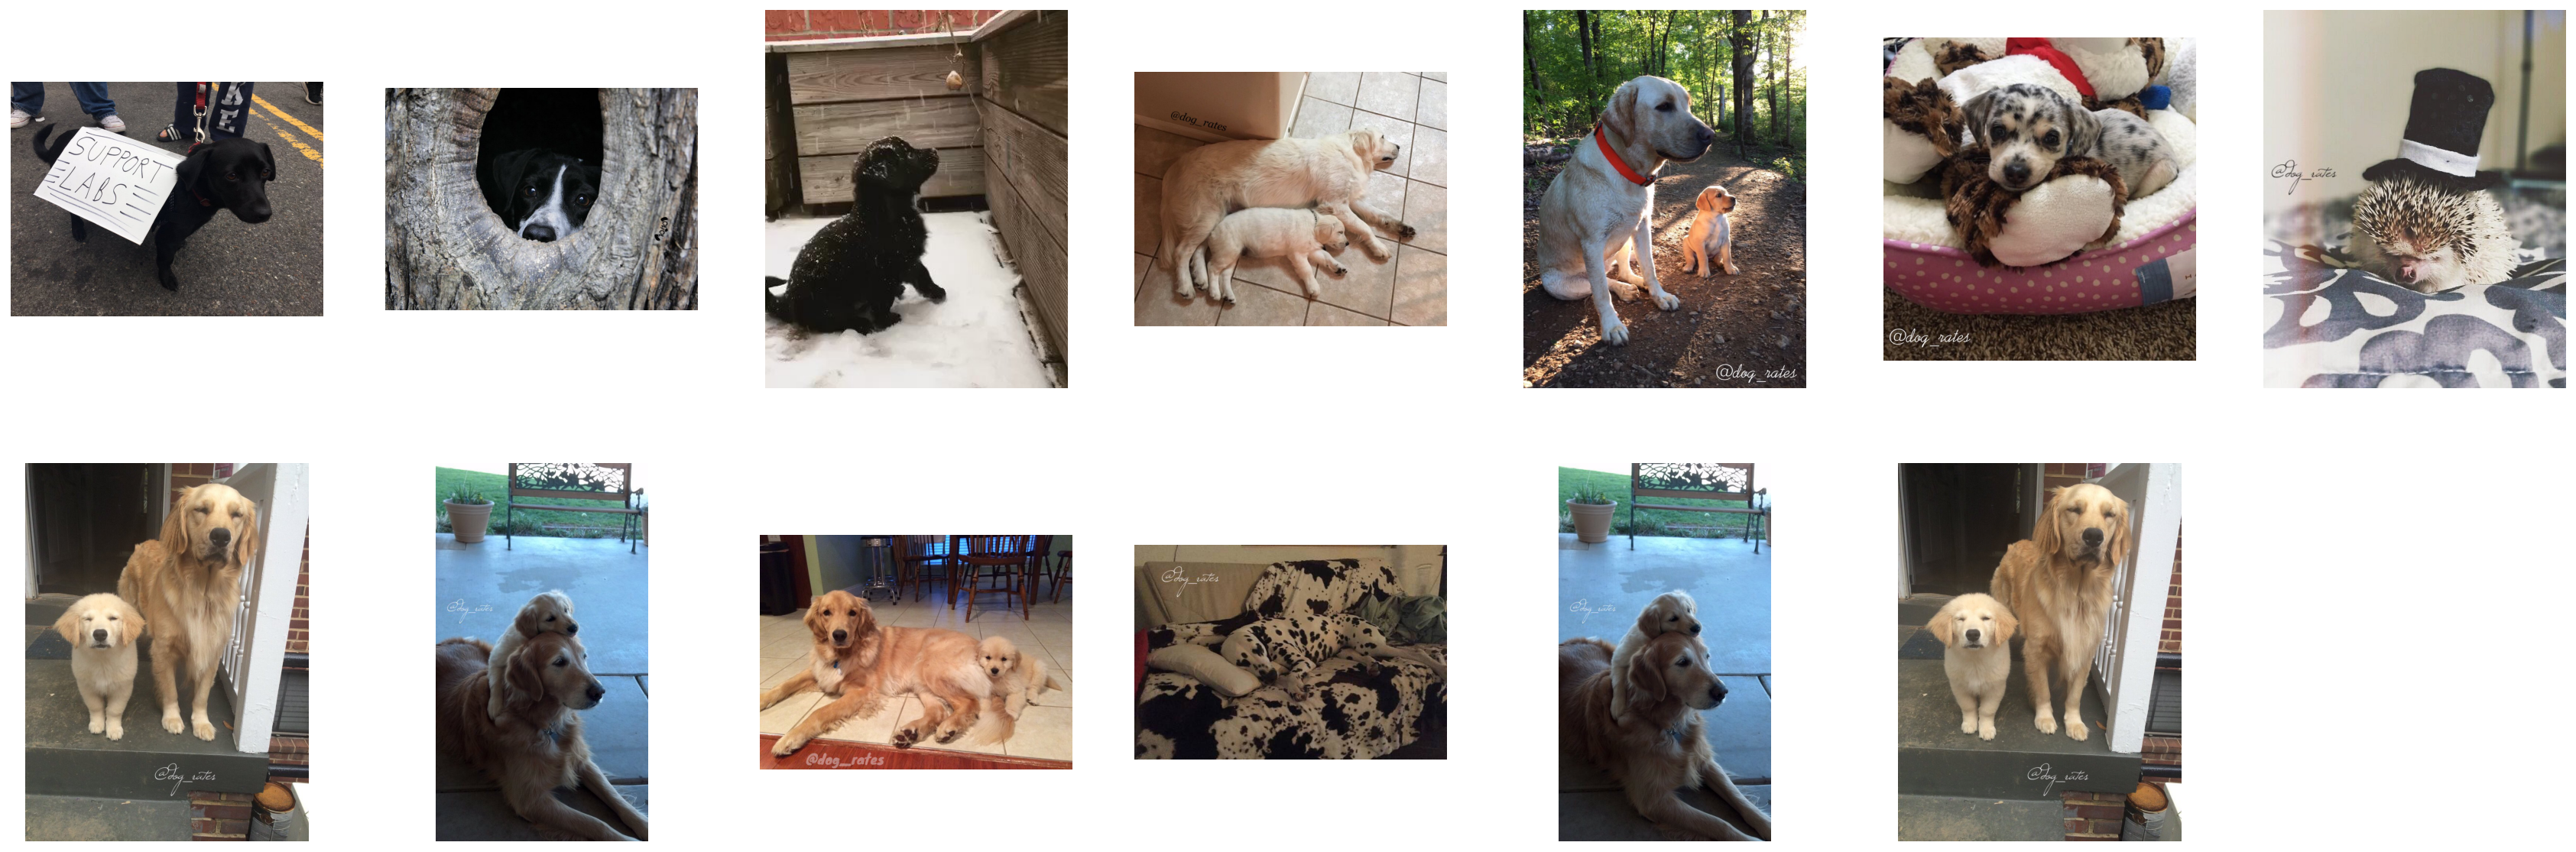

In [122]:
image_list = download_images(urls)

# plot the images
axes = []
fig = plt.figure(figsize=(30,10))
n_rows = 2
n_cols = 7

for i, img in enumerate(image_list):
    axes.append(fig.add_subplot(n_rows, n_cols, i+1));
    plt.imshow(img);
    plt.axis("off");

So, as announced I am not a dog expert and I have no clue whats going on, so I just drop the duplicates. The dataset is large enough to do so without introducing bias and at least we had a look at some cute dog fotos.

In [123]:
complete_df.drop_duplicates("tweet_id", inplace=True)

In [124]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 4712 to 6729
Data columns (total 27 columns):
expanded_urls                 2297 non-null object
favorite_count                2356 non-null int64
img_num                       2075 non-null float64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
jpg_url                       2075 non-null object
name                          2356 non-null object
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null object
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null object
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null object
rating_denominator            2356 non-null int64
rating_numerator     

---

**Define**: Dog race prediction are three seperate columns, and confidence as well  
**Code**: Melt the dataframe into 2 columns, one for predictions (1-3) and one for conf (1-3)   
**Test**: Use .info()   

In [125]:
# melt down the dataframe prediction column
melt_pred = ["p1", "p2", "p3"]
id_cols = complete_df.columns.difference(melt_pred)

complete_df_melt = complete_df.melt(id_vars = id_cols, 
                                   value_vars = melt_pred,
                                   var_name = "prediction_level",
                                   value_name = "prediction_output")

complete_df_melt.prediction_level.nunique()

3

In [126]:
# melt down the dataframe prediction_confidence column
melt_pred = ["p1_conf", "p2_conf", "p3_conf"]
id_cols = complete_df_melt.columns.difference(melt_pred)

complete_df_melt = complete_df_melt.melt(id_vars = id_cols, 
                                   value_vars = melt_pred,
                                   var_name = "prediction_conf_level",
                                   value_name = "prediction_conf_output")

complete_df_melt.prediction_conf_level.nunique()

3

In [127]:
# melt down the dataframe prediction_dog column
melt_pred = ["p1_dog", "p2_dog", "p3_dog"]
id_cols = complete_df_melt.columns.difference(melt_pred)

complete_df_melt = complete_df_melt.melt(id_vars = id_cols, 
                                   value_vars = melt_pred,
                                   var_name = "prediction_dog_level",
                                   value_name = "prediction_dog_output")

complete_df_melt.prediction_dog_level.nunique()

3

**Define**: Dog_cat is type string, as well as dog_prediction column  
**Code**: Convert to category   
**Test**: Use .info()   

In [128]:
print(complete_df_melt.dog_cat.dtype)                  # -> categoric
print(complete_df_melt.prediction_conf_level.dtype)    # -> sorted categoric
print(complete_df_melt.prediction_level.dtype)         # -> sorted categoric
print(complete_df_melt.prediction_dog_level.dtype)     # -> sorted categoric

object
object
object
object


In [129]:
# convert to category
complete_df_melt.dog_cat = complete_df_melt.dog_cat.astype("category")

In [130]:
# these can be ordered categoric levels, as p1 is more important than p2 and p3

pred_levels = ["p1", "p2", "p3"]
pred_classes = pd.api.types.CategoricalDtype(ordered=True, 
                                            categories=pred_levels)
complete_df_melt.prediction_level = complete_df_melt.prediction_level.astype(pred_classes)
complete_df_melt.prediction_level.dtype

CategoricalDtype(categories=['p1', 'p2', 'p3'], ordered=True)

In [131]:
# these can be ordered categoric levels, as p1_conf is more important than p2_conf and p3_conf

pred_conf_levels = ["p1_conf", "p2_conf", "p3_conf"]
pred_conf_classes = pd.api.types.CategoricalDtype(ordered=True, 
                                            categories=pred_conf_levels)
complete_df_melt.prediction_conf_level = complete_df_melt.prediction_conf_level.astype(pred_conf_classes)
complete_df_melt.prediction_conf_level.dtype

CategoricalDtype(categories=['p1_conf', 'p2_conf', 'p3_conf'], ordered=True)

In [132]:
# these can be ordered categoric levels, as p1_dog is more important than p2_dog and p3_dog

pred_dog_levels = ["p1_dog", "p2_dog", "p3_dog"]
pred_dog_classes = pd.api.types.CategoricalDtype(ordered=True, 
                                            categories=pred_dog_levels)
complete_df_melt.prediction_dog_level = complete_df_melt.prediction_dog_level.astype(pred_dog_classes)
complete_df_melt.prediction_dog_level.dtype

CategoricalDtype(categories=['p1_dog', 'p2_dog', 'p3_dog'], ordered=True)

In [82]:
### complete_df_melt.prediction_dog_output = complete_df_melt.prediction_dog_output.astype(float)

In [133]:
complete_df_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63612 entries, 0 to 63611
Data columns (total 24 columns):
dog_cat                       63612 non-null category
expanded_urls                 62019 non-null object
favorite_count                63612 non-null int64
img_num                       56025 non-null float64
in_reply_to_status_id         63612 non-null object
in_reply_to_user_id           63612 non-null object
jpg_url                       56025 non-null object
name                          63612 non-null object
prediction_conf_level         63612 non-null category
prediction_conf_output        56025 non-null float64
prediction_level              63612 non-null category
prediction_output             56025 non-null object
rating_denominator            63612 non-null int64
rating_numerator              63612 non-null int64
retweet_count                 63612 non-null int64
retweeted_status_id           63612 non-null object
retweeted_status_timestamp    4887 non-null datetime64[

---

Finally, in order to later visualise the ratings better (altough this is not a real objective rating, but just something funny), lets create a `rating score` by dividing numerator/denominator

In [134]:
complete_df_melt["rating"] = complete_df_melt["rating_numerator"] / complete_df_melt["rating_denominator"]
complete_df_melt["rating"]

0        1.3
1        1.3
2        1.2
3        1.3
4        1.2
        ... 
63607    0.9
63608    1.2
63609    1.1
63610    0.9
63611    0.8
Name: rating, Length: 63612, dtype: float64

### 9. Save data

In [135]:
complete_df_melt.to_csv("WeRateDogs_clean_melted_preds.csv",index=False)
complete_df.to_csv("WeRateDogs_clean.csv",index=False)

In [136]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///WeRateDogs.db")

complete_df_melt.to_sql("WeRateDogs_clean_melted_preds", engine, index=False, if_exists = "replace")
complete_df.to_sql("WeRateDogs_clean", engine, index=False, if_exists = "replace")

---
---

## 10. Analyse the data

> **`Key questions`**
1. How does the distribution of `retweets` and `likes` look like?
2. Who is the most retweeted dog?
3. Who are the top rated dogs?

---

1. How does the distribution of `retweets` and `likes` look like?

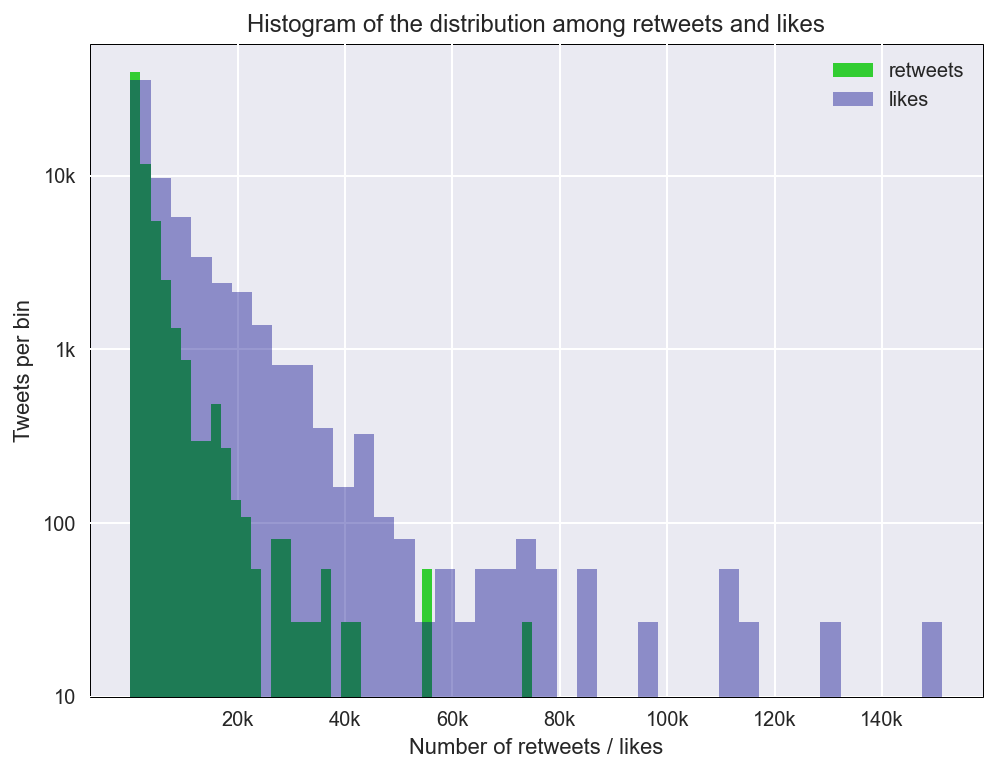

In [139]:
# since we keep working with only 1 dataframe rename it for easier handling
df = complete_df_melt.copy()

plt.style.use("seaborn");

# plot the distribution of the retweet count
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(df.retweet_count, bins=40, color="limegreen", alpha=1, label="retweets");
ax.hist(df.favorite_count, bins=40, color="darkblue", alpha=0.4, label="likes");
plt.title("Histogram of the distribution among retweets and likes")
plt.yscale("log");
plt.yticks([10,100,1000,10000], ["10","100","1k","10k"])
plt.xticks([20000,40000,60000,80000,100000,120000,140000], ["20k","40k","60k","80k","100k","120k","140k"])
plt.xlabel("Number of retweets / likes")
plt.ylabel("Tweets per bin")
ax.legend(loc="upper right")
ax.patch.set_edgecolor("black");
ax.patch.set_linewidth("0.5");
fig.savefig("Favorite_and_Retweet_Count.png")

>**`Key findings`**  Most of the tweets range across the lower border of retweets and likes, but some reach a very high level of likes (above 140k). As expected like rates are higher than retweeting, because giving a like is much faster and easier and less effort than retweeting. Next, lets have a look who the most retweeted dog is.

---

2. Who is the most retweeted dog?

In [141]:
# Who is the most retweeted dog?

data = df.loc[df.retweet_count == df.retweet_count.max(),["jpg_url", "name"]]
urls = set(data["jpg_url"])
urls

{'https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg'}

In [146]:
print(set(data["name"]))
# unfortunately this dog has no name :(

{'None'}


Done.


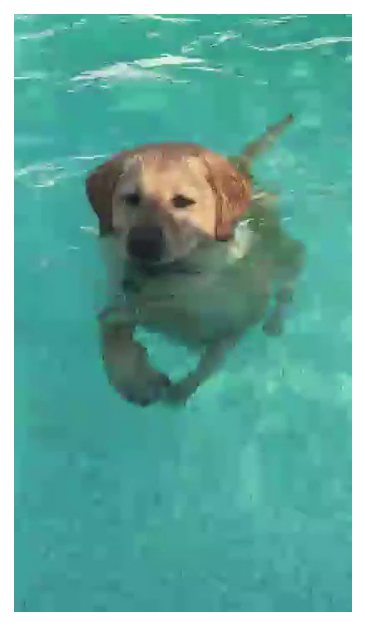

In [167]:
image = download_images(urls);
plt.imshow(image[0]);
plt.axis("off");
plt.savefig("Most_retweeted_dog.png")

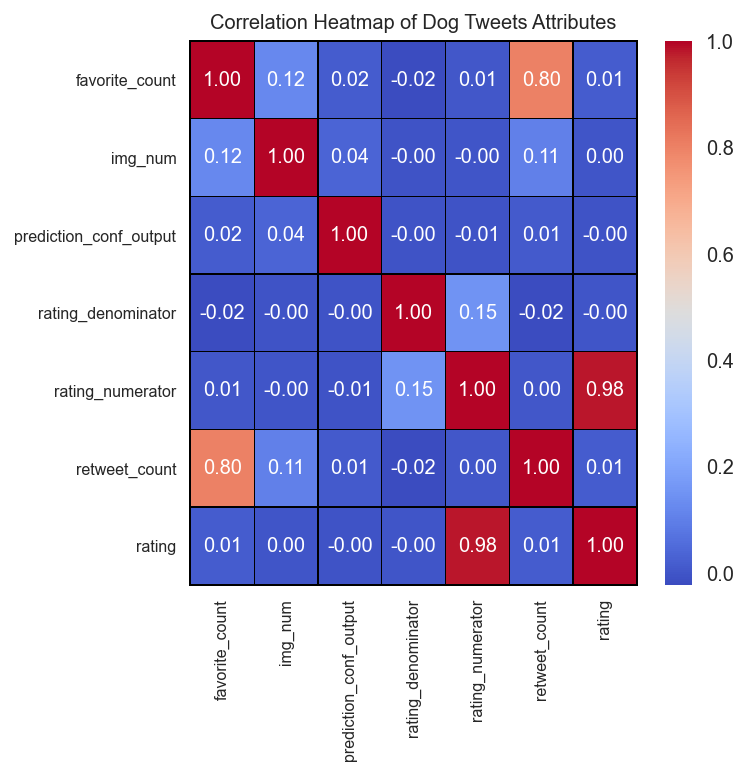

In [161]:
# lets also have a quick look into wheter theres any correlation between ratings, retweets and likes ..

plt.figure(figsize=(5,5))

fig = sns.heatmap(df.corr(),
           cmap="coolwarm", 
           annot=True, fmt = ".2f",
           linewidths=0.1, linecolor="black");
plt.title("Correlation Heatmap of Dog Tweets Attributes", fontsize=10);
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 8);
fig.set_yticklabels(fig.get_xmajorticklabels(), fontsize = 8);
fig.patch.set_edgecolor("black");
fig.patch.set_linewidth("1")  
plt.xticks(rotation=90)
plt.savefig("Correlation.png")

>**`Key findings`**  Retweets and likes correlate quite well (~0.8). This is as expected. However they do not correlate with the rating, most likely because this rating is not a true one but just for fun.

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63612 entries, 0 to 63611
Data columns (total 25 columns):
dog_cat                       63612 non-null category
expanded_urls                 62019 non-null object
favorite_count                63612 non-null int64
img_num                       56025 non-null float64
in_reply_to_status_id         63612 non-null object
in_reply_to_user_id           63612 non-null object
jpg_url                       56025 non-null object
name                          63612 non-null object
prediction_conf_level         63612 non-null category
prediction_conf_output        56025 non-null float64
prediction_level              63612 non-null category
prediction_output             56025 non-null object
rating_denominator            63612 non-null int64
rating_numerator              63612 non-null int64
retweet_count                 63612 non-null int64
retweeted_status_id           63612 non-null object
retweeted_status_timestamp    4887 non-null datetime64[

---

3. Who are the top rated dogs?

In [152]:
# to do so, lets first select rows where the neural network only predicted a dog as outcome and not something weird, like a car or a space shuttle ...
dogs = df[df.prediction_dog_output == 1.0]
dogs.prediction_dog_output.nunique()

1

In [153]:
# remove cuplicated IDs
dogs = dogs.drop_duplicates("tweet_id")

In [154]:
# select the top level dog prediction, then get the prediction_output and count
top_breeds = dogs[dogs.prediction_dog_level == "p1_dog"]["prediction_output"].value_counts()
top_breeds

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
groenendael             1
clumber                 1
standard_schnauzer      1
Scotch_terrier          1
silky_terrier           1
Name: prediction_output, Length: 111, dtype: int64

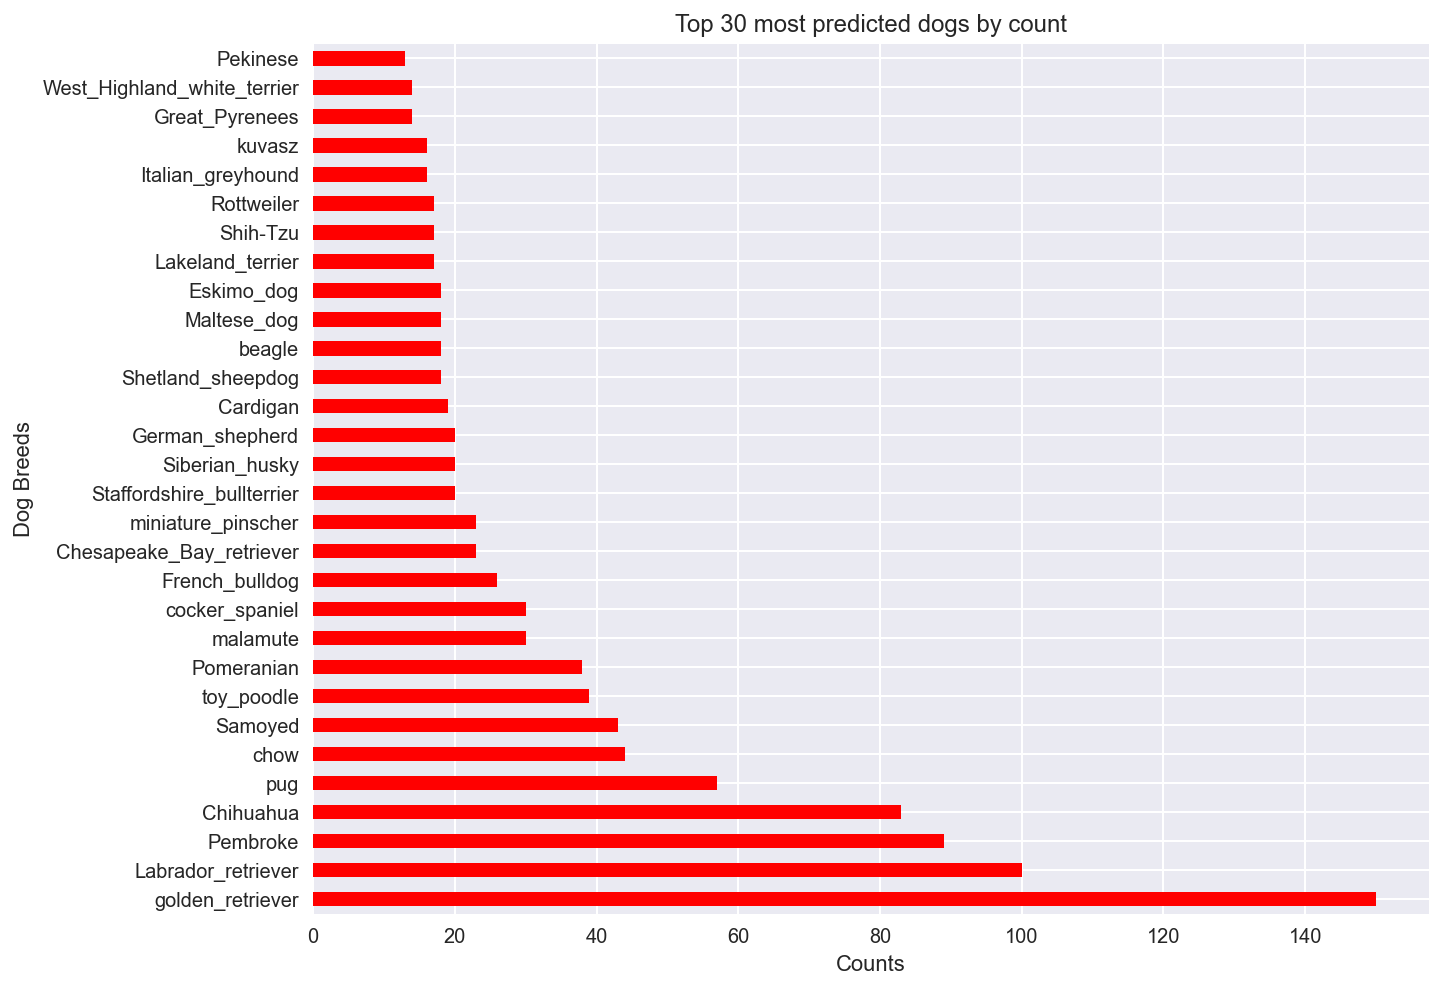

In [157]:
# top 30 predicted dogs
plt.figure(figsize=(10,8));
top_breeds[:30].plot(kind="barh", color="red");
plt.title("Top 30 most predicted dogs by count");
plt.ylabel("Dog Breeds");
plt.xlabel("Counts");
plt.savefig("top30_predicted_dog_by_counts.png")

>**`Key findings`**  Golden retriever are the most often predicted dogs in this dataset, followed with a large distance by labrador retrievers.

Next, lets have a look at the top 30 rated dogs.

In [97]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 1 to 44762
Data columns (total 25 columns):
dog_cat                       1751 non-null category
expanded_urls                 1751 non-null object
favorite_count                1751 non-null int64
img_num                       1751 non-null float64
in_reply_to_status_id         1751 non-null object
in_reply_to_user_id           1751 non-null object
jpg_url                       1751 non-null object
name                          1751 non-null object
prediction_conf_level         1751 non-null category
prediction_conf_output        1751 non-null float64
prediction_level              1751 non-null category
prediction_output             1751 non-null object
rating_denominator            1751 non-null int64
rating_numerator              1751 non-null int64
retweet_count                 1751 non-null int64
retweeted_status_id           1751 non-null object
retweeted_status_timestamp    65 non-null datetime64[ns, UTC]
retweeted_

In [158]:
# just consider the data where the prediction says its a dog on the first level
dogs = dogs[dogs.prediction_dog_level =="p1_dog"]

In [159]:
# group dogs by their respective dog breed output
# then select the rating column that we created before
# count the values of the mean of the ratings in descending order

top_ratings = dogs.groupby("prediction_output").rating.mean().sort_values(ascending=False)
top_ratings

prediction_output
clumber                   2.700000
Pomeranian                1.286842
Saluki                    1.250000
Tibetan_mastiff           1.240000
briard                    1.233333
                            ...   
Welsh_springer_spaniel    0.900000
Ibizan_hound              0.900000
Scotch_terrier            0.900000
Norwich_terrier           0.900000
Japanese_spaniel          0.500000
Name: rating, Length: 111, dtype: float64

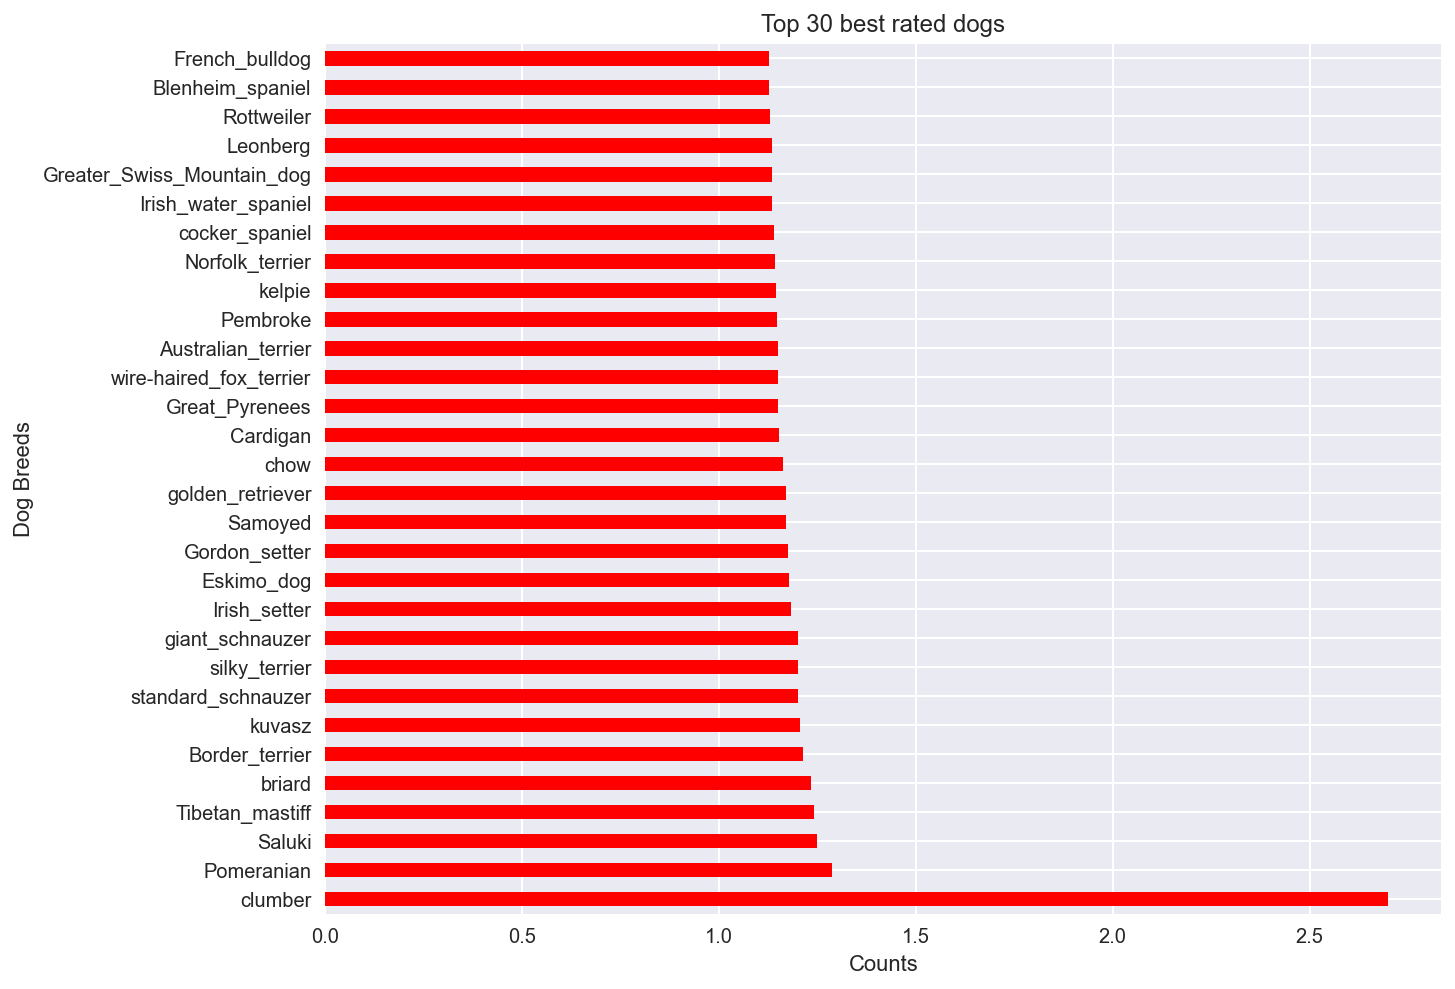

In [160]:
# top 30 rated dogs
plt.figure(figsize=(10,8));
top_ratings[:30].plot(kind="barh", color="red");
plt.title("Top 30 best rated dogs");
plt.ylabel("Dog Breeds");
plt.xlabel("Counts");
plt.savefig("Top30_most_rated_dogs.png")

>**`Key findings`**  Clumber are the highest ranked gods in this dataset with a large distance to pomerians who come second. Next we want to make sure this is not a bias (possibly due to a small sample size of some dog breeds). We will therefore exclude any dog breed from further consideration if it is predicted less than 15 times in the entire dataset.

In [162]:
# select the predicted dog breed and count in descending order
most_rated = dogs["prediction_output"].value_counts().sort_values(ascending=False)
# remove any dog breed that was counted less than 15 times, then select the .index (dog breed name)
most_rated = most_rated[most_rated.values >= 15].index
most_rated

Index(['golden_retriever', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'pug', 'chow', 'Samoyed', 'toy_poodle', 'Pomeranian', 'malamute',
       'cocker_spaniel', 'French_bulldog', 'miniature_pinscher',
       'Chesapeake_Bay_retriever', 'Staffordshire_bullterrier',
       'Siberian_husky', 'German_shepherd', 'Cardigan', 'Shetland_sheepdog',
       'beagle', 'Maltese_dog', 'Eskimo_dog', 'Lakeland_terrier', 'Shih-Tzu',
       'Rottweiler', 'Italian_greyhound', 'kuvasz'],
      dtype='object')

In [163]:
# only include the dog breeds (see above) with more than or equal to 15 observed predictions in our dogs dataset
dogs_subset = dogs.loc[dogs.prediction_output.isin(most_rated),:]

In [164]:
# repeat the step above: group by dog breed prediction, take the rating column we created, take its mean and sort
top_ratings = dogs_subset.groupby("prediction_output").rating.mean().sort_values(ascending=False)
top_ratings

prediction_output
Pomeranian                   1.286842
kuvasz                       1.206250
Eskimo_dog                   1.177778
Samoyed                      1.169767
golden_retriever             1.169645
chow                         1.163636
Cardigan                     1.152632
Pembroke                     1.146067
cocker_spaniel               1.140000
Rottweiler                   1.129412
French_bulldog               1.126923
Siberian_husky               1.125000
Labrador_retriever           1.113000
toy_poodle                   1.112821
German_shepherd              1.100000
malamute                     1.090000
Lakeland_terrier             1.082353
Chihuahua                    1.080723
Staffordshire_bullterrier    1.080000
Chesapeake_Bay_retriever     1.078261
miniature_pinscher           1.065217
Shih-Tzu                     1.052941
beagle                       1.044444
Shetland_sheepdog            1.038889
pug                          1.031579
Italian_greyhound            0.9

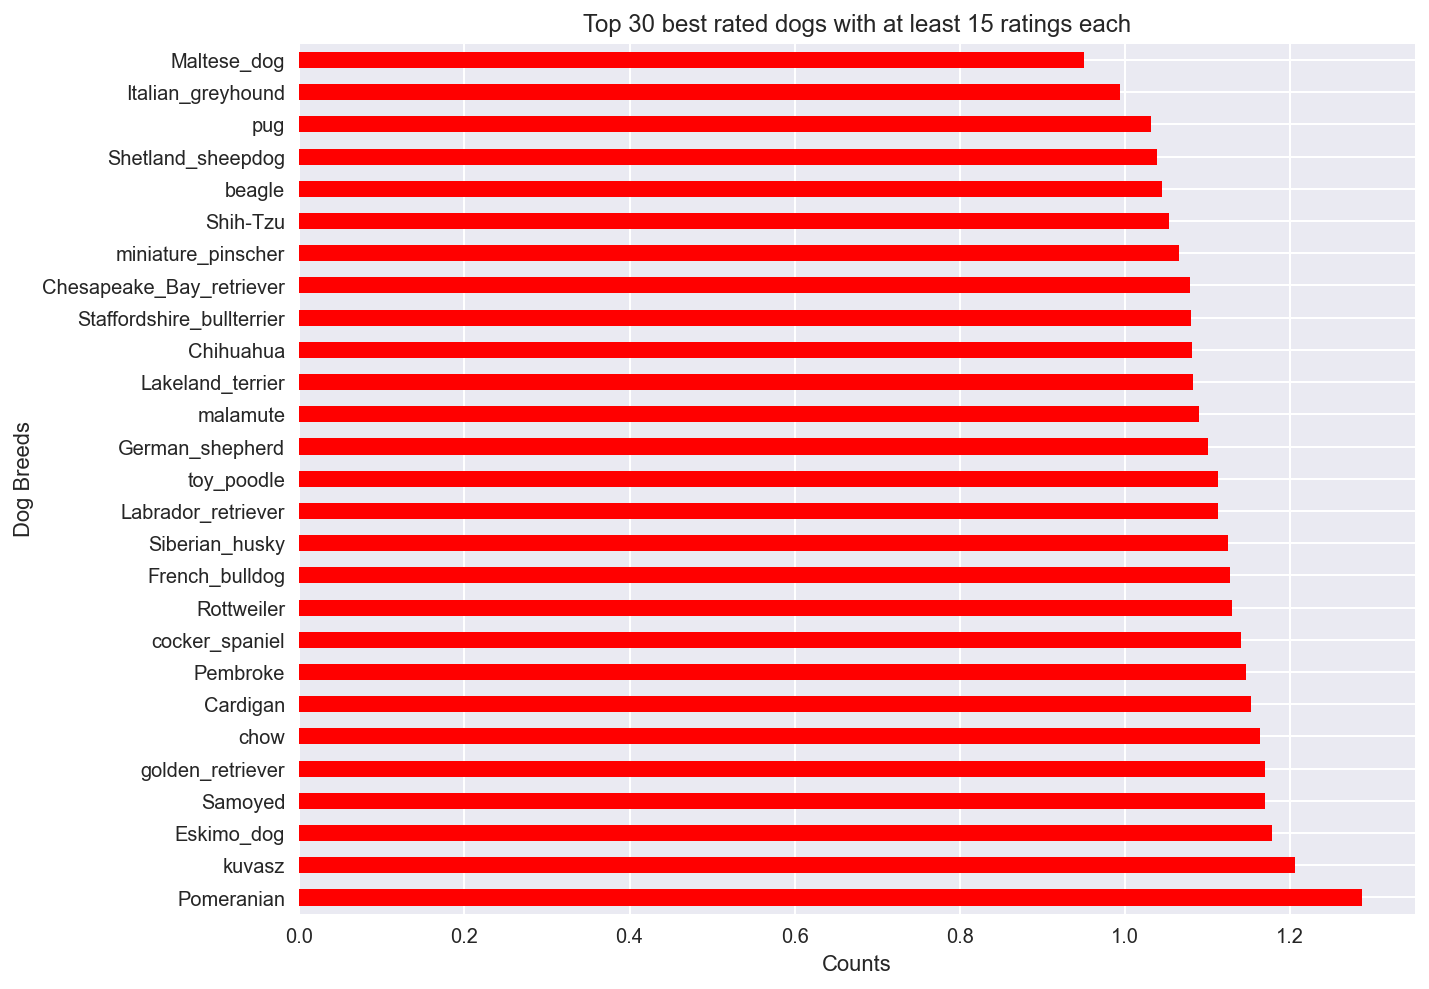

In [168]:
# top 30 rated dogs
plt.figure(figsize=(10,8));
top_ratings[:30].plot(kind="barh", color="red");
plt.title("Top 30 best rated dogs with at least 15 ratings each");
plt.ylabel("Dog Breeds");
plt.xlabel("Counts");
plt.savefig("Top30_most_rated_dogs_atleast15.png")

>**`Key findings`**  Considering only dogs whose breed was observed at least 15 times, pomeranians are the top rated dogs now, not clumbers.

### 11. Store final output .csv

In [166]:
# finally, save our dataframe
complete_df_melt.to_csv("twitter_archive_master.csv",index=False)